In [1]:
# import pandas, numpy

import pandas as pd
import numpy as np
import datetime as dt

pd.set_option('display.max_columns', 200)

In [2]:
# read in data

allstar = pd.read_csv("./baseballdatabank-2019.2/core/AllstarFull.csv")
appear = pd.read_csv("./baseballdatabank-2019.2/core/Appearances.csv")
awardplay = pd.read_csv("./baseballdatabank-2019.2/core/AwardsPlayers.csv")
batting = pd.read_csv("./baseballdatabank-2019.2/core/Batting.csv")
battingpost = pd.read_csv("./baseballdatabank-2019.2/core/BattingPost.csv")
fielding = pd.read_csv("./baseballdatabank-2019.2/core/Fielding.csv")

#fieldingof = pd.read_csv("./baseballdatabank-2019.2/core/FieldingOF.csv")

fieldingofsplit = pd.read_csv("./baseballdatabank-2019.2/core/FieldingOFsplit.csv")
fieldingpost = pd.read_csv("./baseballdatabank-2019.2/core/FieldingPost.csv")


hof = pd.read_csv("./baseballdatabank-2019.2/core/HallOfFame.csv")
hof.drop(columns=['votedBy', 'ballots', 'needed', 'votes', 'needed_note'], axis=1, inplace=True)

people = pd.read_csv("./baseballdatabank-2019.2/core/People.csv")
people.drop(columns = ['birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathCountry', 'deathDay', 'deathState', 'deathCity', 'nameGiven'], axis=1, inplace=True)

# pitch = pd.read_csv("./baseballdatabank-2019.2/core/Pitching.csv")
# pitchpost = pd.read_csv("./baseballdatabank-2019.2/core/PitchingPost.csv")
# salaries = pd.read_csv("./baseballdatabank-2019.2/core/Salaries.csv")
fangraph = pd.read_csv("./FanGraphs Leaderboard.csv")

In [3]:
# drop people who have not ended their careers or who never played a game

debutnotnull = people[people['debut'].notnull()]
finalgamenotnull = people[people['finalGame'].notnull()]
people = pd.concat([debutnotnull,finalgamenotnull]).drop_duplicates()

# make people debut and final game columns into dates
people['debut'] = pd.to_datetime(people['debut'])
people['finalGame'] = pd.to_datetime(people['finalGame'])

# get difference between debuts and final games
people['careerlength'] = people['finalGame'] - people['debut']
# converts careerlength to # days
people['careerlength'] = people['careerlength'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

people['recentretire'] = dt.datetime.now() - people['finalGame']
people['recentretire'] = people['recentretire'].astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)

# get careers > about 7 years
people = people[people['careerlength'] > 2000]

# remove those who retired < 5 years ago
people = people[people['recentretire'] > 1825]

people['Name'] = people['nameFirst'] + ' ' + people['nameLast']

In [4]:
# in our learning, we are looking at all players who didn't make the Hall, not
# just those who were voted on
# so, we can remove those from the hall table that got nos, just leaving the yes
hof = hof[hof['inducted'] == 'Y']

# remove non-players from the hall
hof = hof[hof['category'] == 'Player']

# remove players from the hall that are not in our people table
peopinhall = pd.merge(people, hof, on='playerID').drop_duplicates()['playerID']
hof = hof[hof['playerID'].isin(peopinhall)]

In [5]:
stats = {'G' : 0, 'AB' : 0, 'R' : 0, 'H' : 0, '2B' : 0, '3B' : 0, 'HR' : 0, 'RBI' : 0, 'SB' : 0, 'CS' : 0, 'BB' : 0, 'SO' : 0, 'IBB' : 0, 'HBP' : 0, 'SH' : 0, 'SF' : 0, 'GIDP' : 0}

# replace NaNs in batting with 0s
batting.fillna(value=stats)
battingpost.fillna(value=stats)

# only get batting of people in our table
batting = batting[batting['playerID'].isin(people['playerID'])]
battingpost = battingpost[battingpost['playerID'].isin(people['playerID'])]

In [6]:
careerstats = batting.groupby('playerID').agg({'G' : np.sum, 'AB' : np.sum, 'R' : np.sum, 'H' : np.sum, '2B': np.sum, '3B' : np.sum, 'HR' : np.sum, 'RBI' : np.sum, 'SB' : np.sum, 'CS' : np.sum, 'BB' : np.sum, 'SO' : np.sum, 'IBB' : np.sum, 'HBP' : np.sum, 'SH' : np.sum, 'SF' : np.sum, 'GIDP' : np.sum})
careerpoststats = battingpost.groupby('playerID').agg({'G' : np.sum, 'AB' : np.sum, 'R' : np.sum, 'H' : np.sum, '2B': np.sum, '3B' : np.sum, 'HR' : np.sum, 'RBI' : np.sum, 'SB' : np.sum, 'CS' : np.sum, 'BB' : np.sum, 'SO' : np.sum, 'IBB' : np.sum, 'HBP' : np.sum, 'SH' : np.sum, 'SF' : np.sum, 'GIDP' : np.sum})

# filter out at-bats or games
# filter out at-bats / game
# or filter out games
# 500 games seems like a good standard
careerstats = careerstats[careerstats['G'] >= 500]
careerstats['ABPG'] = careerstats['AB'] / careerstats['G']
careerstats = careerstats[careerstats['ABPG'] >= 1] 
carrerstats = careerstats[careerstats['AB'] >= 1000]

careerpoststats['ABPG'] = careerpoststats['AB'] / careerpoststats['G']
careerpoststats = careerpoststats[careerpoststats['ABPG'] >= 1]

# careerstats.count()
# this leaves us with 2664 players, 212 of which are in the Hall of Fame

In [7]:
# get appearances of only people in our table
appear = appear[appear['playerID'].isin(people['playerID'])]

stats = {'G_all' : 0, 'GS' : 0, 'G_batting' : 0, 'G_defense' : 0, 'G_p' : 0, 'G_c' : 0, 'G_1b' : 0, 'G_2b' : 0, 'G_3b' : 0, 'G_ss' : 0, 'G_lf' : 0, 'G_cf' : 0, 'G_rf' : 0, 'G_of' : 0, 'G_dh' : 0, 'G_ph' : 0, 'G_pr' : 0}
appear.fillna(value=stats)

careerapp = appear.groupby('playerID').agg({'G_all' : np.sum, 'G_batting' : np.sum, 'G_defense' : np.sum, 'G_p' : np.sum, 'G_c' : np.sum, 'G_1b' : np.sum, 'G_2b' : np.sum, 'G_3b' : np.sum, 'G_ss' : np.sum, 'G_lf' : np.sum, 'G_cf' : np.sum, 'G_rf' : np.sum, 'G_of' : np.sum, 'G_dh' : np.sum, 'G_ph' : np.sum, 'G_pr' : np.sum})

careerapp = careerapp[careerapp['G_all'] >= 500]
careerapp['pitchpct'] = careerapp['G_p'] / careerapp['G_all']
careerapp = careerapp[careerapp['pitchpct'] < .75]

In [8]:
fielding = fielding[fielding['playerID'].isin(people['playerID'])]
stats = {'G' : 0, 'GS' : 0, 'InnOuts' : 0, 'PO' : 0, 'A' : 0, 'E' : 0, 'DP' : 0, 'PB' : 0, 'WP' : 0, 'SB' : 0, 'CS' : 0, 'ZR' : 0}
fielding.fillna(value=stats)
stats = {'G' : 0, 'GS' : 0, 'InnOuts' : 0, 'PO' : 0, 'A' : 0, 'E' : 0, 'DP' : 0, 'TP' : 0, 'PB' : 0, 'SB' : 0, 'CS' : 0}
fieldingpost.fillna(value=stats)

careerfield = fielding.groupby('playerID').agg({'G' : np.sum, 'GS' : np.sum, 'InnOuts' : np.sum, 'PO' : np.sum, 'A' : np.sum, 'E' : np.sum, 'DP' : np.sum, 'PB' : np.sum, 'WP' : np.sum, 'SB' : np.sum, 'CS' : np.sum, 'ZR' : np.sum})
careerpostfield = fieldingpost.groupby('playerID').agg({'G' : np.sum, 'GS' : np.sum, 'InnOuts' : np.sum, 'PO' : np.sum, 'A' : np.sum, 'E' : np.sum, 'DP' : np.sum, 'PB' : np.sum, 'TP' : np.sum, 'SB' : np.sum, 'CS' : np.sum})

careerfield = careerfield[careerfield['G'] >= 500]

In [9]:
# awards
awardplay = awardplay[awardplay['playerID'].isin(people['playerID'])]
awardplay['pitchtriplecrown'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Pitching Triple Crown' else 0)
awardplay['triplecrown'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Triple Crown' else 0)
awardplay['baseballmagallstar'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Baseball Magazine All-Star' else 0)
awardplay['mvp'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Most Valuable Player' else 0)
awardplay['tsnallstar'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN All-Star' else 0)
awardplay['tsnguidemvp'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN Guide MVP' else 0)
awardplay['tsnmlpoty'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN Major League Player of the Year' else 0)
awardplay['tsnpitcheroty'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN Pitcher of the Year' else 0)
awardplay['tsnpoty'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN Player of the Year' else 0)
awardplay['roty'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Rookie of the Year' else 0)
awardplay['baberuth'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Babe Ruth Award' else 0)
awardplay['lou'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Lou Gehrig Memorial Award' else 0)
awardplay['wsmvp'] = awardplay['awardID'].apply(lambda x : 1 if x == 'World Series MVP' else 0)
awardplay['cyyoung'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Cy Young Award' else 0)
awardplay['goldglove'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Gold Glove' else 0)
awardplay['fireman'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN Fireman of the Year' else 0)
awardplay['asgmvp'] = awardplay['awardID'].apply(lambda x : 1 if x == 'All-Star Game MVP' else 0)
awardplay['hutch'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Hutch Award' else 0)
awardplay['clemente'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Roberto Clemente Award' else 0)
awardplay['relief'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Rolaids Relief Man Award' else 0)
awardplay['nlcsmvp'] = awardplay['awardID'].apply(lambda x : 1 if x == 'NLCS MVP' else 0)
awardplay['alcsmvp'] = awardplay['awardID'].apply(lambda x : 1 if x == 'ALCS MVP' else 0)
awardplay['silver'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Silver Slugger' else 0)
awardplay['branchrickey'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Branch Rickey Award' else 0)
awardplay['hankaaron'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Hank Arron Award' else 0)
awardplay['tsnrelief'] = awardplay['awardID'].apply(lambda x : 1 if x == 'TSN Reliever of the Year Award' else 0)
awardplay['comeback'] = awardplay['awardID'].apply(lambda x : 1 if x == 'Comeback Player of the Year' else 0)

careerawards = awardplay.groupby('playerID').agg({'pitchtriplecrown' : np.sum, 'triplecrown' : np.sum, 'baseballmagallstar' : np.sum, 
                                                 'mvp' : np.sum, 'tsnallstar' : np.sum, 'tsnguidemvp' : np.sum, 'tsnmlpoty' : np.sum,
                                                 'tsnpitcheroty' : np.sum, 'tsnpoty' : np.sum, 'roty' : np.sum, 'baberuth' : np.sum,
                                                 'lou' : np.sum, 'wsmvp' : np.sum, 'cyyoung' : np.sum, 'goldglove' : np.sum,
                                                 'fireman' : np.sum, 'asgmvp' : np.sum, 'hutch' : np.sum, 'clemente' : np.sum,
                                                 'relief' : np.sum, 'nlcsmvp' : np.sum, 'alcsmvp' : np.sum, 'silver' : np.sum,
                                                 'branchrickey' : np.sum, 'hankaaron' : np.sum, 'tsnrelief' : np.sum,
                                                 'comeback' : np.sum})

In [10]:
fanpeop = pd.merge(people, fangraph, on='Name')
fanpeop = pd.merge(careerstats, fanpeop, on='playerID')

In [11]:
hofers = pd.merge(people, hof, on='playerID')
hofbats = pd.merge(careerstats, hof, on='playerID')
hofpost = pd.merge(careerpoststats, hof, on='playerID')
hofapp = pd.merge(careerapp, hof, on='playerID')
hoffield = pd.merge(careerfield, hof, on='playerID')
hoffieldpost = pd.merge(careerpostfield, hof, on='playerID')
hofawards = pd.merge(careerawards, hof, on='playerID')
# hofers.count()
# 229
# hofbats.count()
# 203
# hofpost.count()
# 189
# hofapp.count()
# 160
# hoffield.count()
# 209
# hoffieldpost.count()
# 182
# hofawards.count()
# 195

In [12]:
fanpeop.rename(index=str, columns={"G_x" : "Career Stats G", "AB" : "Career Stats AB", "R_x" : "Career Stats R", "H" : "Career Stats H",
                                  "2B" : "Career Stats 2B", "3B" : "Career Stats 3B", "HR_x" : "Career Stats HR",
                                  "RBI_x" : "Career Stats RBI", "SB_x" : "Career Stats SB", "CS" : "Career Stats CS",
                                  "BB" : "Career Stats BB", "SO" : "Career Stats SO", "IBB" : "Career Stats IBB", 
                                  "HBP" : "Career Stats HBP", "SH" : "Career Stats SH", "SF": "Career Stats SF",
                                  "GIDP" : "Career Stats GIDP", "G_y" : "FanGraphs G", "PA" : "FanGraphs PA",
                                  "HR_y" : "FanGraphs HR", "R_y" : "FanGraphs R", "RBI_y" : "FanGraphs RBI",
                                  "SB_y" : "FanGraphs SB"}, inplace=True)
fanpeop.drop(columns=['nameFirst', 'nameLast', 'debut', 'finalGame', 'retroID', 'bbrefID', 'recentretire',
                     'Name', 'Team', 'playerid'], axis=1, inplace=True)

In [13]:
data = fanpeop
data = pd.merge(data, careerawards, on='playerID', how='left').drop_duplicates()
data.drop(columns=['ABPG', 'pitchtriplecrown', 'tsnpitcheroty', 'cyyoung', 'relief', 'tsnrelief'],axis=1, inplace=True)
data.rename(index=str, columns={'pitchtriplecrown' : "Pitching Triple Crown", 'triplecrown' : "Triple Crown",
                               'baseballmagallstar' : "Baseball Mag All-Star", 'mvp' : "MVP", 'tsnallstar' : "TSN All-Star",
                               'tsnguidemvp' : "TSN Guide MVP", 'tsnmlpoty' : "TSN ML POTY", 'tsnpoty' : "TSN POTY",
                               'roty' : "Rookie of the Year", 'baberuth' : "Babe Ruth Award", 'lou' : "Lou Gehrig Memorial Award",
                               'wsmvp' : "World Series MVP", 'goldglove' : "Gold Glove", 'fireman' : "TSN Fireman of the Year",
                               'asgmvp' : "ASG MVP", 'hutch' : "Hutch Award", 'clemente' : "Roberto Clemente Award",
                               'nlcsmvp' : "NLCS MVP", 'alcsmvp' : "ALCS MVP", 'silver' : "Silver Slugger", 
                               'branchrickey' : "Branch Rickey Award", 'hankaaron' : "Hank Aaron Award", 
                               'comeback' : "Comeback Player of the Year"}, inplace=True)

In [14]:
data = pd.merge(data, careerfield, on='playerID', how='left').drop_duplicates()
data.drop(columns=['WP', 'SB', 'CS', 'ZR', 'PB'],axis=1, inplace=True)
data.rename(index=str, columns={'G' : 'Games Fielding', 'GS' : 'GS Fielding', 'InnOuts' : 'Inning Outs Fielding',
                               'PO' : 'PO Fielding', 'A' : 'A Fielding', 'E' : 'E Fielding',
                               'DP' : 'DP Fielding'},inplace=True)

In [15]:
data = pd.merge(data, careerpostfield, on='playerID', how='left').drop_duplicates()
data.drop(columns=['PB', 'TP', 'CS', 'SB'], axis=1, inplace=True)
data.rename(index=str, columns={'G' : 'G Fielding Post', 'GS' : 'GS Fielding Post', 'InnOuts' : 'Inning Outs Fielding Post', 
                               'PO' : 'PO Fielding Post', 'A' : 'A Fielding Post', 'E' : 'E Fielding Post',
                               'DP' : 'DP Fielding Post'},inplace=True)

In [16]:
data = pd.merge(data, careerpoststats, on='playerID', how='left').drop_duplicates()
data.drop(columns=['ABPG'], axis=1,inplace=True)
data.rename(index=str, columns={'G' : 'G Post', 'AB' : 'AB Post', 'R' : 'R Post', 'H' : 'H Post', '2B' : '2B Post',
                               '3B' : '3B Post', 'HR' : 'HR Post', 'RBI' : 'RBI Post' ,'SB' : 'SB Post', 'CS' : 'CS Post',
                               'BB' : 'BB Post', 'SO' : 'SO Post', 'IBB' : 'IBB Post', 'HBP' : 'HBP Post', 
                               'SH' : 'SH Post', 'SF' : 'SF Post', 'GIDP' : 'GIDP Post'},inplace=True)

In [17]:
data = data.drop_duplicates()
data = data.fillna(0)
data['Bats'] = data['bats'].apply(lambda x : 1 if x == 'R' else 0)
data['Throws'] = data['throws'].apply(lambda x : 1 if x == 'R' else 0)
data.drop(columns=['bats', 'throws'], axis=1, inplace=True)

In [18]:
data['K%'] = data['K%'].astype(str)
data['K%'] = data['K%'].str.replace(' %$', '')
data['BB%'] = data['BB%'].astype(str)
data['BB%'] = data['BB%'].str.replace(' %$', '')
data = data.replace('nan', 50)
data[['K%', 'BB%']] = data[['K%', 'BB%']].apply(pd.to_numeric)

In [19]:
collist = data.columns.tolist()
data[collist[1:]] = data[collist[1:]].apply(pd.to_numeric)

In [20]:
hoferslist = hofers.columns.tolist()
hofers = hofers[hoferslist[0]]
hoflist = hofers.tolist()
data['HOF'] = data['playerID'].apply(lambda x : 1 if x in hoflist else 0) 

In [21]:
hoflessgames = data[(data['Career Stats G'] < 1000) & (data['HOF'] == 1)]
data = data[data['Career Stats G'] >= 1000]

data = pd.concat([data, hoflessgames]).drop_duplicates()

In [22]:
labels = data.iloc[:,[-1]].as_matrix()
labels = np.squeeze(np.asarray(labels))
data.drop(columns=['HOF', 'FanGraphs G', 'FanGraphs PA', 'FanGraphs R', 'FanGraphs RBI', 'Baseball Mag All-Star', 'TSN All-Star',
                  'careerlength'], axis=1, inplace=True)

C:\Users\tas12\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [23]:
dataMat = data.iloc[:,1:].as_matrix()

C:\Users\tas12\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [24]:
# data

#TODO: make sure that we have the correct thresholds for stats we want

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

data_new = SelectKBest(mutual_info_classif, k=20).fit_transform(dataMat, labels)

In [26]:
data_frame = data[data.columns[1:]]

selector = SelectKBest(mutual_info_classif, k=25)
selector.fit(data_frame, labels)
# Get columns to keep
cols = selector.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
data_reduct = data_frame.iloc[:,cols]

In [64]:
ix = np.asarray(np.where(np.isin(labels, 1)))
ix = ix[0]
hof_reduct = data_reduct.iloc[ix,:]
ixnot = np.asarray(np.where(np.isin(labels,0)))
ixnot = ixnot[0]
nothof_reduct = data_reduct.iloc[ixnot,:]

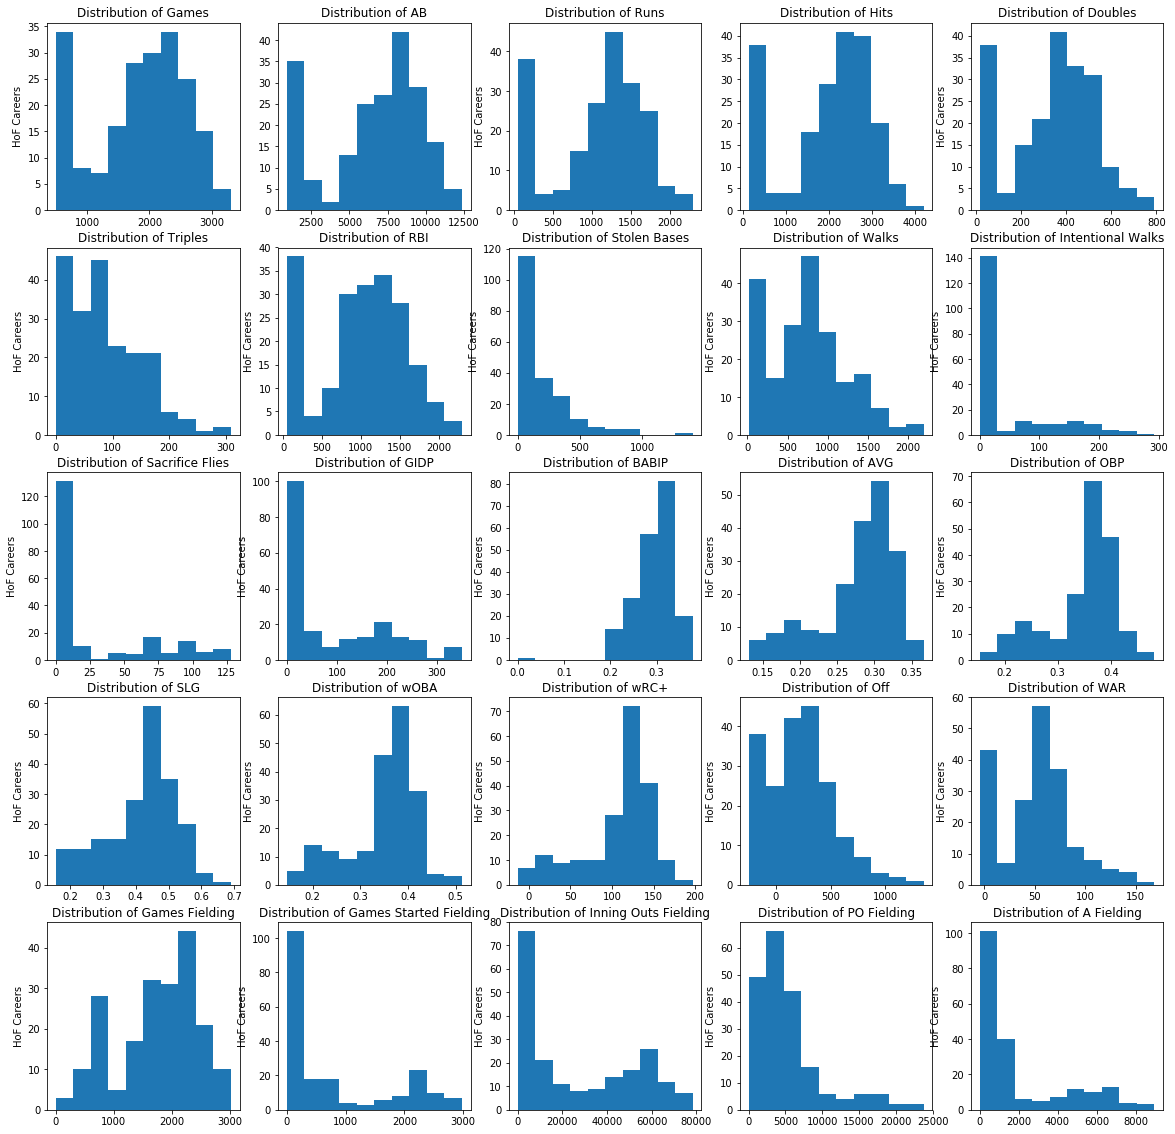

In [48]:
import matplotlib.pyplot as plt

# Initialize the figure and add subplots
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(5,5,1)
ax2 = fig.add_subplot(5,5,2)
ax3 = fig.add_subplot(5,5,3)
ax4 = fig.add_subplot(5,5,4)
ax5 = fig.add_subplot(5,5,5)
ax6 = fig.add_subplot(5,5,6)
ax7 = fig.add_subplot(5,5,7)
ax8 = fig.add_subplot(5,5,8)
ax9 = fig.add_subplot(5,5,9)
ax10 = fig.add_subplot(5,5,10)
ax11 = fig.add_subplot(5,5,11)
ax12 = fig.add_subplot(5,5,12)
ax13 = fig.add_subplot(5,5,13)
ax14 = fig.add_subplot(5,5,14)
ax15 = fig.add_subplot(5,5,15)
ax16 = fig.add_subplot(5,5,16)
ax17 = fig.add_subplot(5,5,17)
ax18 = fig.add_subplot(5,5,18)
ax19 = fig.add_subplot(5,5,19)
ax20 = fig.add_subplot(5,5,20)
ax21 = fig.add_subplot(5,5,21)
ax22 = fig.add_subplot(5,5,22)
ax23 = fig.add_subplot(5,5,23)
ax24 = fig.add_subplot(5,5,24)
ax25 = fig.add_subplot(5,5,25)

# Create distribution plots for Hits, Home Runs, Years Played and All Star Games
ax1.hist(hof_reduct['Career Stats G'])
ax1.set_title('Distribution of Games')
ax1.set_ylabel('HoF Careers')
ax2.hist(hof_reduct['Career Stats AB'])
ax2.set_title('Distribution of AB')
ax3.hist(hof_reduct['Career Stats R'])
ax3.set_title('Distribution of Runs')
ax3.set_ylabel('HoF Careers')
ax4.hist(hof_reduct['Career Stats H'])
ax4.set_title('Distribution of Hits')
ax5.hist(hof_reduct['Career Stats 2B'])
ax5.set_title('Distribution of Doubles')
ax5.set_ylabel('HoF Careers')

ax6.hist(hof_reduct['Career Stats 3B'])
ax6.set_title('Distribution of Triples')
ax6.set_ylabel('HoF Careers')

ax7.hist(hof_reduct['Career Stats RBI'])
ax7.set_title('Distribution of RBI')
ax7.set_ylabel('HoF Careers')

ax8.hist(hof_reduct['Career Stats SB'])
ax8.set_title('Distribution of Stolen Bases')
ax8.set_ylabel('HoF Careers')

ax9.hist(hof_reduct['Career Stats BB'])
ax9.set_title('Distribution of Walks')
ax9.set_ylabel('HoF Careers')

ax10.hist(hof_reduct['Career Stats IBB'])
ax10.set_title('Distribution of Intentional Walks')
ax10.set_ylabel('HoF Careers')

ax11.hist(hof_reduct['Career Stats SF'])
ax11.set_title('Distribution of Sacrifice Flies')
ax11.set_ylabel('HoF Careers')

ax12.hist(hof_reduct['Career Stats GIDP'])
ax12.set_title('Distribution of GIDP')
ax12.set_ylabel('HoF Careers')

ax13.hist(hof_reduct['BABIP'])
ax13.set_title('Distribution of BABIP')
ax13.set_ylabel('HoF Careers')

ax14.hist(hof_reduct['AVG'])
ax14.set_title('Distribution of AVG')
ax14.set_ylabel('HoF Careers')

ax15.hist(hof_reduct['OBP'])
ax15.set_title('Distribution of OBP')
ax15.set_ylabel('HoF Careers')

ax16.hist(hof_reduct['SLG'])
ax16.set_title('Distribution of SLG')
ax16.set_ylabel('HoF Careers')

ax17.hist(hof_reduct['wOBA'])
ax17.set_title('Distribution of wOBA')
ax17.set_ylabel('HoF Careers')

ax18.hist(hof_reduct['wRC+'])
ax18.set_title('Distribution of wRC+')
ax18.set_ylabel('HoF Careers')

ax19.hist(hof_reduct['Off'])
ax19.set_title('Distribution of Off')
ax19.set_ylabel('HoF Careers')

ax20.hist(hof_reduct['WAR'])
ax20.set_title('Distribution of WAR')
ax20.set_ylabel('HoF Careers')

ax21.hist(hof_reduct['Games Fielding'])
ax21.set_title('Distribution of Games Fielding')
ax21.set_ylabel('HoF Careers')

ax22.hist(hof_reduct['GS Fielding'])
ax22.set_title('Distribution of Games Started Fielding')
ax22.set_ylabel('HoF Careers')

ax23.hist(hof_reduct['Inning Outs Fielding'])
ax23.set_title('Distribution of Inning Outs Fielding')
ax23.set_ylabel('HoF Careers')

ax24.hist(hof_reduct['PO Fielding'])
ax24.set_title('Distribution of PO Fielding')
ax24.set_ylabel('HoF Careers')

ax25.hist(hof_reduct['A Fielding'])
ax25.set_title('Distribution of A Fielding')
ax25.set_ylabel('HoF Careers')

stats = ['wOBA', 'wRC+', 'Off', 'WAR', 'Games Fielding', 'GS Fielding',
       'Inning Outs Fielding', 'PO Fielding', 'A Fielding']

plt.show()

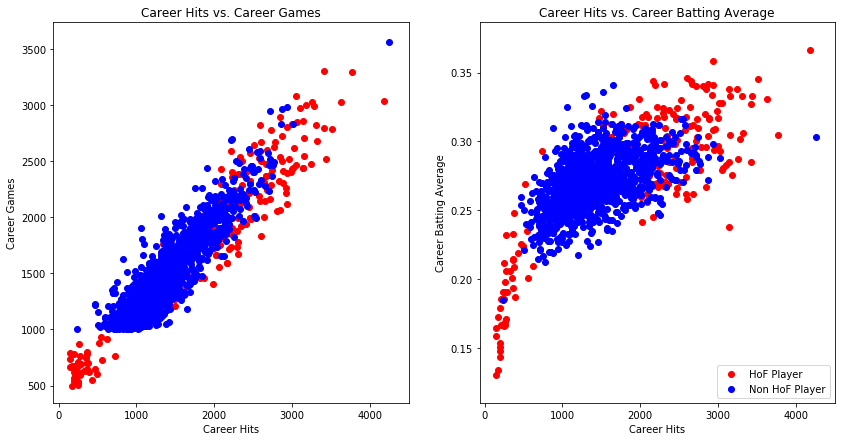

In [67]:
# Initialize the figure and add subplots
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Create Scatter plots for Hits vs. Average and Home Runs vs. Average
ax1.scatter(hof_reduct['Career Stats H'], hof_reduct['Career Stats G'], c='r', label='HoF Player')
ax1.scatter(nothof_reduct['Career Stats H'], nothof_reduct['Career Stats G'], c='b', label='Non HoF Player')
ax1.set_title('Career Hits vs. Career Games')
ax1.set_xlabel('Career Hits')
ax1.set_ylabel('Career Games')
ax2.scatter(hof_reduct['Career Stats H'], hof_reduct['AVG'], c='r', label='HoF Player')
ax2.scatter(nothof_reduct['Career Stats H'], nothof_reduct['AVG'], c='b', label='Non HoF Player')
ax2.set_title('Career Hits vs. Career Batting Average')
ax2.set_ylabel('Career Batting Average')
ax2.set_xlabel('Career Hits')
ax2.legend(loc='lower right', scatterpoints=1)

# Show the plot
plt.show()

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

logisticreg = LogisticRegression(penalty='l2', tol=0.01, solver='lbfgs')
logisticreg.fit(data_reduct, labels)
coef = logisticreg.coef_.ravel()

In [63]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y = True)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X, y)
clf.predict(X[:2, :]) # predict labels of first two samples of X
clf.predict_proba(X[:2, :]) #probability estimates of first two samples in X (3 classes)
clf.score(X, y)

0.9733333333333334